In [1]:
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 80.5 MB/s eta 0:00:0000:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.76
    Uninstalling botocore-1.29.76:
      Successfully uninstalled botocore-1.29.76
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.5.0 requires botocore<1.29.77,>=1.29.76, but you have botocore 1.29.153 which is incompatible.


In [2]:
!cp -r /kaggle/input/metal-nut/* /kaggle/working

In [3]:
import boto3
import uuid, os
from datetime import date

current_date = date.today()
date_name = current_date.strftime("%Y-%m-%d")

ACCESS_KEY = os.environ.get('AWS_ACCESS_KEY_ID')
SECRET_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')
BUCKET_NAME = os.environ.get('BUCKET_NAME')
DATASET_NAME = "cycle-gan/metal_nut"
METAL_NAME = "weights.zip"
METAL_PATH = f"{DATASET_NAME}/metal_nut_weights-{date_name}.zip"

session = boto3.Session(
    aws_access_key_id=ACCESS_KEY, 
    aws_secret_access_key=SECRET_KEY
)

s3 = session.resource('s3')
bucket = s3.Bucket(BUCKET_NAME)

# Introduction

In this project, we will attempt to greate a Cycle Generative Adversarial Network (cycleGAN) in order to manipulate defective industrial parts. We will attempt to augment images data.

Our first step is to load the neccessary libraries we will be using for the entire process.

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
import random
import imageio
import cv2
from torchvision import transforms
from PIL import Image
import os , itertools
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

Since we are using two platforms, we will be assigning a directory to the location of the data for each platform. This will make it easier to access the data, depending the platform we will be using.

The two platforms will be:
1. A local installation of  Jupyter Notebook - work on local codes. GPU is limited
2. A Google Colaboratory Notebook - Use of available resources and GPU to run the model

In [5]:
data_dir = 'metal_nut'
train_dir = os.path.join(data_dir,'train')
test_dir = os.path.join(data_dir,'test')

## Parameters

In this block, we will create global parameters which we can use at different areas of this project.

In [6]:
# Creating the Parameters

parameters = {
    'batch_size': 1,
    'input_size': 256,
    'resize_scale': 286,
    'crop_size': 256,
    'fliplr':True,
    
    # Model parameters
    'num_epochs': 800,
    'decay_epoch': 100,
    'ngf': 32,   # Number of generator filters
    'ndf': 64,   # Number of discriminator filters
    'num_resnet': 6, # Number of resnet blocks
    'lrG': 0.0002,    # Learning rate for generator
    'lrD': 0.0002,    # Learning rate for discriminator
    'beta1': 0.5 ,    # Beta1 for Adam optimizer
    'beta2': 0.999 ,  # Beta2 for Adam optimizer
    'lambdaA': 10 ,   # LambdaA for cycle loss
    'lambdaB': 10  ,  # LambdaB for cycle loss
}
          

## Creating functions

In the next set, we will create several functions that will be used throughout. The first function will convert our data into Numpy, which we can call at a later point.

We will also set a variable so we can use a GPU for faster processing.

In [7]:
# Convert to Numpy 
def to_numpy(x):
    return x.data.cpu().numpy()

# Use GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
!mkdir training_images

### Transformer

Since we will be using a __transformer__ at a later stage, we will set a transformer variable and assign it procedures which transforms an image size accordingly. This transformer will also convert the image into a Tensor and Normalize it as well.

In [9]:
transform = transforms.Compose([
    transforms.Resize(size=parameters['input_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


Defining a function which will __plot__ the result from training

In [10]:
def plot_train_result(real_image, gen_image, recon_image, epoch, save=True,  show=False, fig_size=(15, 15)):
    fig, axes = plt.subplots(2, 3, figsize=fig_size)
    fig.subplots_adjust(wspace=0, hspace=0)
    imgs = [to_numpy(real_image[0]), to_numpy(gen_image[0]), to_numpy(recon_image[0]),
            to_numpy(real_image[1]), to_numpy(gen_image[1]), to_numpy(recon_image[1])]
    for ax, img in zip(axes.flatten(), imgs):
        ax.axis('off');
        #ax.set_adjustable('box-forced')
        # Scale to 0-255
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
        ax.imshow(img, cmap=None, aspect='equal')
    # save figure
    if save:
        save_fn = f"training_images/Result_epoch_{epoch + 1}.png"
        plt.savefig(save_fn, bbox_inches='tight', pad_inches=0)

    if show:
        plt.show()
    else:
        plt.close()

Next, we will define an __ImagePool__ function

In [11]:
class ImagePool():
    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        if self.pool_size == 0:
            return images
        return_images = []
        for image in images.data:
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size-1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

### Creating the Dataloader

In this section, we begin by creating the __dataloader__ which we will use to retrieve the data in parts.

In [12]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, subfolder='train', transform=None, resize_scale=None, crop_size=None, fliplr=False):
        super(DatasetFromFolder, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.image_filenames = [x for x in sorted(os.listdir(self.input_path))]
        self.transform = transform

        self.resize_scale = resize_scale
        self.crop_size = crop_size
        self.fliplr = fliplr

    def __getitem__(self, index):
        # Load Image
        img_fn = os.path.join(self.input_path, self.image_filenames[index])
        img = Image.open(img_fn).convert('RGB')

        # preprocessing
        if self.resize_scale:
            img = img.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)

        if self.crop_size:
            x = random.randint(0, self.resize_scale - self.crop_size + 1)
            y = random.randint(0, self.resize_scale - self.crop_size + 1)
            img = img.crop((x, y, x + self.crop_size, y + self.crop_size))
        if self.fliplr:
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)

        if self.transform is not None:
            img = self.transform(img)

        return img

    def __len__(self):
        return len(self.image_filenames)

### Creating the Convolutional Block

The __convolution__ block will consist of two things.

1. Initialization

2. Forward pass.

In [13]:
class ConvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,activation='relu',batch_norm=True):
        super(ConvBlock,self).__init__()
        self.conv = torch.nn.Conv2d(input_size,output_size,kernel_size,stride,padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
        self.lrelu = torch.nn.LeakyReLU(0.2,True)
        self.tanh = torch.nn.Tanh()
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.conv(x))
        else:
            out = self.conv(x)

        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out


### De-Convolution Function

In this class we will create, we will need to bring back the convolution from the results previously processed. There will be two functions inside this class.

1. Initialization

2. Forward pass

In [14]:
class DeconvBlock(torch.nn.Module):
    def __init__(self,input_size,output_size,kernel_size=3,stride=2,padding=1,output_padding=1,activation='relu',batch_norm=True):
        super(DeconvBlock,self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size,output_size,kernel_size,stride,padding,output_padding)
        self.batch_norm = batch_norm
        self.bn = torch.nn.InstanceNorm2d(output_size)
        self.activation = activation
        self.relu = torch.nn.ReLU(True)
    def forward(self,x):
        if self.batch_norm:
            out = self.bn(self.deconv(x))
        else:
            out = self.deconv(x)
        if self.activation == 'relu':
            return self.relu(out)
        elif self.activation == 'lrelu':
            return self.lrelu(out)
        elif self.activation == 'tanh':
            return self.tanh(out)
        elif self.activation == 'no_act':
            return out


### Residual Learning Block

In this secton, we will create a __residual learning__ block or __Resnet__. This class will also contain two functions.

1. Initialization

2. Forward pass

In [15]:
class ResnetBlock(torch.nn.Module):
    def __init__(self,num_filter,kernel_size=3,stride=1,padding=0):
        super(ResnetBlock,self).__init__()
        conv1 = torch.nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding)
        conv2 = torch.nn.Conv2d(num_filter,num_filter,kernel_size,stride,padding)
        bn = torch.nn.InstanceNorm2d(num_filter)
        relu = torch.nn.ReLU(True)
        pad = torch.nn.ReflectionPad2d(1)

        self.resnet_block = torch.nn.Sequential(pad, conv1, bn, relu, pad, conv2, bn)
    def forward(self,x):
        out = self.resnet_block(x)
        return out

## Creating the Generator

We will now create the __Generator__. The Generator will consist of the following:
1. Encoder
2. Transformer
3. Decoder

In addition, we will also be adding __weights__.

After creating the class, we will create the actuall Generator.

In [16]:
class Generator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim,num_resnet):
        super(Generator,self).__init__()

        # Reflection padding
        self.pad = torch.nn.ReflectionPad2d(3)
        # Encoder
        self.conv1 = ConvBlock(input_dim,num_filter,kernel_size=7,stride=1,padding=0)
        self.conv2 = ConvBlock(num_filter,num_filter*2)
        self.conv3 = ConvBlock(num_filter*2,num_filter*4)
        # Resnet blocks
        self.resnet_blocks = []
        for i in range(num_resnet):
            self.resnet_blocks.append(ResnetBlock(num_filter*4))
        self.resnet_blocks = torch.nn.Sequential(*self.resnet_blocks)
        #Decoder
        self.deconv1 = DeconvBlock(num_filter*4,num_filter*2)
        self.deconv2 = DeconvBlock(num_filter*2,num_filter)
        self.deconv3 = ConvBlock(num_filter,output_dim,kernel_size=7,stride=1,padding=0,activation='tanh',batch_norm=False)

    def forward(self,x):
        # Encoder
        enc1 = self.conv1(self.pad(x))
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        # Resnet blocks
        res = self.resnet_blocks(enc3)
        # Decoder
        dec1 = self.deconv1(res)
        dec2 = self.deconv2(dec1)
        out = self.deconv3(self.pad(dec2))
        return out

    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
            if isinstance(m,DeconvBlock):
                torch.nn.init.normal_(m.deconv.weight,mean,std)
            if isinstance(m,ResnetBlock):
                torch.nn.init.normal_(m.conv.weight,mean,std)
                torch.nn.init.constant_(m.conv.bias,0)


### Creating the Generator and Testing the Neural Network

Since we will be using a Cycle GAN, which requires 2 Neural Networks competing with each other, we will create 2 Generators as its requirement. We will also test it by calling it and view the results created earlier.

#### Generator A

In [17]:
G_A = Generator(3, parameters['ngf'], 3, parameters['num_resnet']).cuda() # input_dim, num_filter, output_dim, num_resnet
G_A.normal_weight_init(mean=0.0, std=0.02)
G_A

Generator(
  (pad): ReflectionPad2d((3, 3, 3, 3))
  (conv1): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (bn): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (resnet_blocks): Sequential(
    (0): ResnetB

#### Generator B

Repeating the previous step, but for Generator B.

In [18]:
G_B = Generator(3, parameters['ngf'], 3, parameters['num_resnet']).cuda()
G_B.normal_weight_init(mean=0.0, std=0.02)
G_B

Generator(
  (pad): ReflectionPad2d((3, 3, 3, 3))
  (conv1): ConvBlock(
    (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1))
    (bn): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): ReLU(inplace=True)
    (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
    (tanh): Tanh()
  )
  (resnet_blocks): Sequential(
    (0): ResnetB

## Creating the Discriminator

The Discriminator will consist of the following
1. Initialization
2. Forward Pass
3. Weights

After creating the class, we will create the actuall Discriminator.


In [19]:
class Discriminator(torch.nn.Module):
    def __init__(self,input_dim,num_filter,output_dim):
        super(Discriminator,self).__init__()
        conv1 = ConvBlock(input_dim,num_filter,kernel_size=4,stride=2,padding=1,activation='lrelu',batch_norm=False)
        conv2 = ConvBlock(num_filter,num_filter*2,kernel_size=4,stride=2,padding=1,activation='lrelu')
        conv3 = ConvBlock(num_filter*2,num_filter*4,kernel_size=4,stride=2,padding=1,activation='lrelu')
        conv4 = ConvBlock(num_filter*4,num_filter*8,kernel_size=4,stride=1,padding=1,activation='lrelu')
        conv5 = ConvBlock(num_filter*8,output_dim,kernel_size=4,stride=1,padding=1,activation='no_act',batch_norm=False)
        self.conv_blocks = torch.nn.Sequential(conv1, conv2, conv3, conv4, conv5)
    
    def forward(self,x):
        out = self.conv_blocks(x)
        return out

    def normal_weight_init(self,mean=0.0,std=0.02):
        for m in self.children():
            if isinstance(m,ConvBlock):
                torch.nn.init.normal_(m.conv.weight.data,mean,std)

### Creating the Discriminator and Testing the Neural Network

Similar with the Generator, which requires 2 Neural Networks. A cycleGAN also uses 2 Discriminators.

#### Discriminator A

In [20]:
# Creating the first Discriminator
D_A = Discriminator(3, parameters['ndf'], 1).cuda() # input_dim, num_filter, output_dim
D_A.normal_weight_init(mean=0.0, std=0.02)
D_A

Discriminator(
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): ReLU(inplace=True)
      (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      (tanh): Tanh()
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): ReLU(inplace=True)
      (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      (tanh): Tanh()
    )
    (2): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): ReLU(inplace=True)
      (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      (tanh): Tanh()
    )
    

#### Discriminator B

In [21]:
# Creating the second Discriminator
D_B = Discriminator(3, parameters['ndf'], 1).cuda()
D_B.normal_weight_init(mean=0.0, std=0.02)
D_B

Discriminator(
  (conv_blocks): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): ReLU(inplace=True)
      (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      (tanh): Tanh()
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): ReLU(inplace=True)
      (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      (tanh): Tanh()
    )
    (2): ConvBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (bn): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): ReLU(inplace=True)
      (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      (tanh): Tanh()
    )
    

## Training Block / DataLoaders

In this block, we will create the actual training block we will be using to train our model.

In [22]:
train_data_A = DatasetFromFolder(train_dir, subfolder='good', transform=transform,resize_scale=parameters['resize_scale'], crop_size=parameters['crop_size'], fliplr=parameters['fliplr'])
train_data_loader_A = torch.utils.data.DataLoader(dataset=train_data_A,batch_size=parameters['batch_size'], shuffle=True)
train_data_B = DatasetFromFolder(train_dir, subfolder='bad', transform=transform, resize_scale=parameters['resize_scale'], crop_size=parameters['crop_size'], fliplr=parameters['fliplr'])
train_data_loader_B = torch.utils.data.DataLoader(dataset=train_data_B, batch_size=parameters['batch_size'], shuffle=True)

#Load test data
test_data_A = DatasetFromFolder(test_dir, subfolder='good', transform=transform)
test_data_loader_A = torch.utils.data.DataLoader(dataset=test_data_A, batch_size=parameters['batch_size'], shuffle=False)
test_data_B = DatasetFromFolder(test_dir, subfolder='bad', transform=transform)
test_data_loader_B = torch.utils.data.DataLoader(dataset=test_data_B, batch_size=parameters['batch_size'], shuffle=False)

## Creating the Optimizer

In this block, we need to create the learning optimizers. We will have one optimizer for the Generator and two optimizers for the Discriminator. The Discriminator has two optimizers as this function checks the data generated by the Generator.

In [23]:
G_optimizer = torch.optim.Adam(itertools.chain(G_A.parameters(), G_B.parameters()), lr=parameters['lrG'], betas=(parameters['beta1'], parameters['beta2']))
D_A_optimizer = torch.optim.Adam(D_A.parameters(), lr=parameters['lrD'], betas=(parameters['beta1'], parameters['beta2']))
D_B_optimizer = torch.optim.Adam(D_B.parameters(), lr=parameters['lrD'], betas=(parameters['beta1'], parameters['beta2']))

## Defining Losses

In order to make sure that there is learning, we will create cycle losses, which we will pass on at a later time.

In [24]:
MSE_Loss = torch.nn.MSELoss().cuda()
L1_Loss = torch.nn.L1Loss().cuda()

In [25]:
D_A_avg_losses = []
D_B_avg_losses = []
G_A_avg_losses = []
G_B_avg_losses = []
cycle_A_avg_losses = []
cycle_B_avg_losses = []

## Training the model and retreiving Images



Using the image pool created earliler, we will create a pool of variables which we will be using for training at the next cell block.

In [26]:
num_pool = 50
fake_A_pool = ImagePool(num_pool)
fake_B_pool = ImagePool(num_pool)
test_real_A_data = train_data_A.__getitem__(8).unsqueeze(0)
test_real_B_data = train_data_B.__getitem__(6).unsqueeze(0)
step = 0

We will now run the Training sequence in the block. It is also in these block that learning begins and the time to process the results can take several hours. 

There will be two results displayed below.
1. The epoch number where the learning takes place. This will also include the loss.
2. The image results on how well it did.

In [27]:
for epoch in range(parameters['num_epochs']):
    D_A_losses = []
    D_B_losses = []
    G_A_losses = []
    G_B_losses = []
    cycle_A_losses = []
    cycle_B_losses = []

    # Learing rate decay
    if(epoch + 1) > parameters['decay_epoch']:
        D_A_optimizer.param_groups[0]['lr'] -= parameters['lrD'] / (parameters['num_epochs'] - parameters['decay_epoch'])
        D_B_optimizer.param_groups[0]['lr'] -= parameters['lrD'] / (parameters['num_epochs'] - parameters['decay_epoch'])
        G_optimizer.param_groups[0]['lr'] -= parameters['lrG'] / (parameters['num_epochs'] - parameters['decay_epoch'])


    # training
    for i, (real_A, real_B) in enumerate(zip(train_data_loader_A, train_data_loader_B)):

        # input image data
        real_A = real_A.to(device)
        real_B = real_B.to(device)

        # -------------------------- train generator G --------------------------
        # A --> B
        fake_B = G_A(real_A)
        D_B_fake_decision = D_B(fake_B)
        G_A_loss = MSE_Loss(D_B_fake_decision, Variable(torch.ones(D_B_fake_decision.size()).cuda()))

        # forward cycle loss
        recon_A = G_B(fake_B)
        cycle_A_loss = L1_Loss(recon_A, real_A) * parameters['lambdaA']

        # B --> A
        fake_A = G_B(real_B)
        D_A_fake_decision = D_A(fake_A)
        G_B_loss = MSE_Loss(D_A_fake_decision, Variable(torch.ones(D_A_fake_decision.size()).cuda()))

        # backward cycle loss
        recon_B = G_A(fake_A)
        cycle_B_loss = L1_Loss(recon_B, real_B) * parameters['lambdaB']

        # Back propagation
        G_loss = G_A_loss + G_B_loss + cycle_A_loss + cycle_B_loss
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()


        # -------------------------- train discriminator D_A --------------------------
        D_A_real_decision = D_A(real_A)
        D_A_real_loss = MSE_Loss(D_A_real_decision, Variable(torch.ones(D_A_real_decision.size()).cuda()))

        fake_A = fake_A_pool.query(fake_A)

        D_A_fake_decision = D_A(fake_A)
        D_A_fake_loss = MSE_Loss(D_A_fake_decision, Variable(torch.zeros(D_A_fake_decision.size()).cuda()))

        # Back propagation
        D_A_loss = (D_A_real_loss + D_A_fake_loss) * 0.5
        D_A_optimizer.zero_grad()
        D_A_loss.backward()
        D_A_optimizer.step()

        # -------------------------- train discriminator D_B --------------------------
        D_B_real_decision = D_B(real_B)
        D_B_real_loss = MSE_Loss(D_B_real_decision, Variable(torch.ones(D_B_fake_decision.size()).cuda()))

        fake_B = fake_B_pool.query(fake_B)

        D_B_fake_decision = D_B(fake_B)
        D_B_fake_loss = MSE_Loss(D_B_fake_decision, Variable(torch.zeros(D_B_fake_decision.size()).cuda()))

        # Back propagation
        D_B_loss = (D_B_real_loss + D_B_fake_loss) * 0.5
        D_B_optimizer.zero_grad()
        D_B_loss.backward()
        D_B_optimizer.step()

        # ------------------------ Print -----------------------------
        # loss values
        D_A_losses.append(D_A_loss.item())
        D_B_losses.append(D_B_loss.item())
        G_A_losses.append(G_A_loss.item())
        G_B_losses.append(G_B_loss.item())
        cycle_A_losses.append(cycle_A_loss.item())
        cycle_B_losses.append(cycle_B_loss.item())

        if i % 100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], D_A_loss: %.4f, D_B_loss: %.4f, G_A_loss: %.4f, G_B_loss: %.4f'
                  % (epoch+1, parameters['num_epochs'], i+1, len(train_data_loader_A), D_A_loss.item(), D_B_loss.item(), G_A_loss.item(), G_B_loss.item()))

        step += 1

    D_A_avg_loss = torch.mean(torch.FloatTensor(D_A_losses))
    D_B_avg_loss = torch.mean(torch.FloatTensor(D_B_losses))
    G_A_avg_loss = torch.mean(torch.FloatTensor(G_A_losses))
    G_B_avg_loss = torch.mean(torch.FloatTensor(G_B_losses))
    cycle_A_avg_loss = torch.mean(torch.FloatTensor(cycle_A_losses))
    cycle_B_avg_loss = torch.mean(torch.FloatTensor(cycle_B_losses))

    # avg loss values for plot
    D_A_avg_losses.append(D_A_avg_loss.item())
    D_B_avg_losses.append(D_B_avg_loss.item())
    G_A_avg_losses.append(G_A_avg_loss.item())
    G_B_avg_losses.append(G_B_avg_loss.item())
    cycle_A_avg_losses.append(cycle_A_avg_loss.item())
    cycle_B_avg_losses.append(cycle_B_avg_loss.item())

    # Show result for test image
    test_real_A = test_real_A_data.cuda()
    test_fake_B = G_A(test_real_A)
    test_recon_A = G_B(test_fake_B)

    test_real_B = test_real_B_data.cuda()
    test_fake_A = G_B(test_real_B)
    test_recon_B = G_A(test_fake_A)
    real_image, gen_image, recon_image = [test_real_A, test_real_B], [test_fake_B, test_fake_A], [test_recon_A, test_recon_B]
    
    plot_train_result(real_image, gen_image, recon_image, epoch, save=True)



Epoch [1/800], Step [1/220], D_A_loss: 0.5636, D_B_loss: 0.5741, G_A_loss: 0.9640, G_B_loss: 1.0526
Epoch [2/800], Step [1/220], D_A_loss: 0.3433, D_B_loss: 0.2698, G_A_loss: 0.4069, G_B_loss: 0.4545
Epoch [3/800], Step [1/220], D_A_loss: 0.2917, D_B_loss: 0.5642, G_A_loss: 0.7741, G_B_loss: 0.4260
Epoch [4/800], Step [1/220], D_A_loss: 0.2394, D_B_loss: 0.2314, G_A_loss: 0.2713, G_B_loss: 0.3179
Epoch [5/800], Step [1/220], D_A_loss: 0.2422, D_B_loss: 0.2652, G_A_loss: 0.2806, G_B_loss: 0.3516
Epoch [6/800], Step [1/220], D_A_loss: 0.2007, D_B_loss: 0.2456, G_A_loss: 0.3740, G_B_loss: 0.2978
Epoch [7/800], Step [1/220], D_A_loss: 0.2325, D_B_loss: 0.2016, G_A_loss: 0.1920, G_B_loss: 0.2725
Epoch [8/800], Step [1/220], D_A_loss: 0.2530, D_B_loss: 0.3126, G_A_loss: 0.4644, G_B_loss: 0.4229
Epoch [9/800], Step [1/220], D_A_loss: 0.3334, D_B_loss: 0.1990, G_A_loss: 0.4370, G_B_loss: 0.0942
Epoch [10/800], Step [1/220], D_A_loss: 0.2479, D_B_loss: 0.1406, G_A_loss: 0.2624, G_B_loss: 0.2369

## Retreiving the Loss results

We will not retreive the losses generated after learning and save them to a csv file.

In [28]:
all_losses = pd.DataFrame()
all_losses['D_A_avg_losses'] = D_A_avg_losses
all_losses['D_B_avg_losses'] = D_B_avg_losses
all_losses['G_A_avg_losses'] = G_A_avg_losses
all_losses['G_B_avg_losses'] = G_B_avg_losses
all_losses['cycle_A_avg_losses'] = cycle_A_avg_losses
all_losses['cycle_B_avg_losses'] = cycle_B_avg_losses
all_losses.to_csv('avg_losses',index=False)

In [29]:
all_losses

,D_A_avg_losses,D_B_avg_losses,G_A_avg_losses,G_B_avg_losses,cycle_A_avg_losses,cycle_B_avg_losses
0,0.573369,0.628772,0.457897,0.522464,4.245440,3.092601
1,0.269840,0.403491,0.548563,0.390664,1.774272,1.590263
2,0.321249,0.300996,0.405693,0.390427,1.325014,1.282068
3,0.234560,0.240338,0.318787,0.322963,1.181132,1.128197
4,0.325603,0.243163,0.320896,0.437520,1.123357,1.033479
...,...,...,...,...,...,...
795,0.191144,0.109191,0.547979,0.357468,0.330965,0.294668
796,0.181535,0.094329,0.624696,0.370922,0.315638,0.293253
797,0.171661,0.093940,0.577061,0.370215,0.343368,0.296240
798,0.166954,0.101332,0.592088,0.381840,0.343870,0.295338


In [30]:
#save to csv
all_losses.to_csv('all_losses.csv', index=False)

## Plotting all the Losses

<Figure size 2000x2000 with 0 Axes>

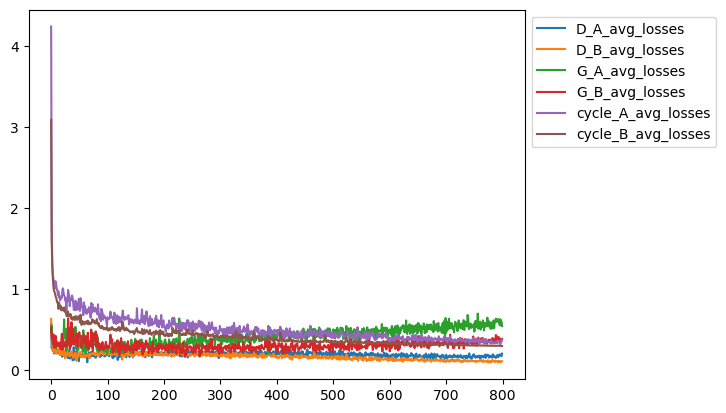

In [31]:
losses = pd.read_csv('all_losses.csv')

plt.figure(figsize=(20,20))
losses.plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()

## Saving the Models to a file

In order to reproduce, use the same model at a later point. We will save the models state_dict created earlier.

In [32]:
# Save Generators
torch.save(G_A.state_dict(), 'Generator_A.pth')
torch.save(G_B.state_dict(), 'Generator_B.pth')

# Save Descriminators
torch.save(D_A.state_dict(), 'Discriminator_A.pth')
torch.save(D_B.state_dict(), 'Discriminator_B.pth')

# Save Optimizers
torch.save(G_optimizer.state_dict(), 'Generator_optimizer.pth')
torch.save(D_A_optimizer.state_dict(), 'Discriminator_A_optimizer.pth')
torch.save(D_B_optimizer.state_dict(), 'Discriminator_B_optimizer.pth')

In [33]:
!zip -r training_images.zip training_images/*

  adding: training_images/Result_epoch_1.png (deflated 0%)
  adding: training_images/Result_epoch_10.png (deflated 0%)
  adding: training_images/Result_epoch_100.png (deflated 0%)
  adding: training_images/Result_epoch_101.png (deflated 0%)
  adding: training_images/Result_epoch_102.png (deflated 0%)
  adding: training_images/Result_epoch_103.png (deflated 0%)
  adding: training_images/Result_epoch_104.png (deflated 0%)
  adding: training_images/Result_epoch_105.png (deflated 0%)
  adding: training_images/Result_epoch_106.png (deflated 0%)
  adding: training_images/Result_epoch_107.png (deflated 0%)
  adding: training_images/Result_epoch_108.png (deflated 0%)
  adding: training_images/Result_epoch_109.png (deflated 0%)
  adding: training_images/Result_epoch_11.png (deflated 0%)
  adding: training_images/Result_epoch_110.png (deflated 0%)
  adding: training_images/Result_epoch_111.png (deflated 0%)
  adding: training_images/Result_epoch_112.png (deflated 0%)
  adding: training_images/Re

In [34]:
!zip -r weights.zip .

  adding: Discriminator_A.pth (deflated 8%)
  adding: metal_nut/ (stored 0%)
  adding: metal_nut/test/ (stored 0%)
  adding: metal_nut/test/good/ (stored 0%)
  adding: metal_nut/test/good/003.png (deflated 0%)
  adding: metal_nut/test/good/006.png (deflated 0%)
  adding: metal_nut/test/good/004.png (deflated 0%)
  adding: metal_nut/test/good/017.png (deflated 0%)
  adding: metal_nut/test/good/013.png (deflated 0%)
  adding: metal_nut/test/good/000.png (deflated 0%)
  adding: metal_nut/test/good/016.png (deflated 0%)
  adding: metal_nut/test/good/008.png (deflated 0%)
  adding: metal_nut/test/good/002.png (deflated 0%)
  adding: metal_nut/test/good/018.png (deflated 0%)
  adding: metal_nut/test/good/012.png (deflated 0%)
  adding: metal_nut/test/good/011.png (deflated 0%)
  adding: metal_nut/test/good/014.png (deflated 0%)
  adding: metal_nut/test/good/005.png (deflated 0%)
  adding: metal_nut/test/good/009.png (deflated 0%)
  adding: metal_nut/test/good/020.png (deflated 0%)
  adding: 

In [35]:
try:
    bucket.upload_file(Key=METAL_PATH, Filename=METAL_NAME)
    print(f'File {METAL_NAME} uploaded to S3 bucket {BUCKET_NAME}')
except:
    print("Something went wrong")

File weights.zip uploaded to S3 bucket lmpthree
